In [2]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [3]:
X = ((X / 255.) - .5) * 2

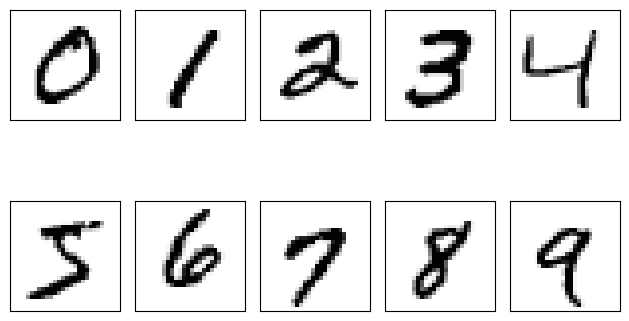

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

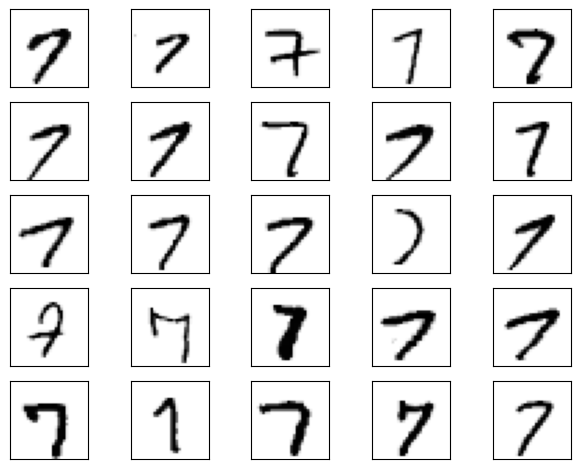

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=10000, random_state=123, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

In [13]:
import numpy as np


def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary


class NeuralNetMLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        self.num_classes = num_classes
        rng = np.random.RandomState(random_seed)
        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):
        y_onehot = int_to_onehot(y, self.num_classes)
        d_loss__d_a_out = 2. * (a_out - y_onehot) / y.shape[0]
        d_a_out__d_z_out = a_out * (1. - a_out)
        delta_out = d_loss__d_a_out * d_a_out__d_z_out
        d_z_out__dw_out = a_h
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        d_z_out__a_h = self.weight_out
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        d_a_h__d_z_h = a_h * (1. - a_h)
        d_z_h__d_w_h = x
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)
        return (d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss__d_b_h)

In [14]:
model = NeuralNetMLP(num_features=28 * 28, num_hidden=50, num_classes=10)

In [15]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]


for i in range(num_epochs):
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
    for X_train_mini, y_train_mini in minibatch_gen:
        break
    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [16]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas) ** 2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)
predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'검증 세트 MSE : {mse:.1f}')
print(f'검증 세트 정확도 : {acc * 100:.1f}%')

검증 세트 MSE : 0.3
검증 세트 정확도 : 9.4%


In [17]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas) ** 2)
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss
    mse = mse / i
    acc = correct_pred / num_examples
    return mse, acc

In [18]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'검증 세트 MSE : {mse:.1f}')
print(f'검증 세트 정확도 : {acc * 100:.1f}%')

검증 세트 MSE : 0.3
검증 세트 정확도 : 9.4%


In [19]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    for e in range(num_epochs):
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
        for X_train_mini, y_train_mini in minibatch_gen:
            a_h, a_out = model.forward(X_train_mini)
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = model.backward(X_train_mini, a_h, a_out,
                                                                                            y_train_mini)
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc * 100, valid_acc * 100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'에포크: {e + 1:03d}/{num_epochs:03d} '
              f'| 훈련 MSE : {train_mse:.2f} '
              f'| 훈련 정확도 : {train_acc:.2f}% '
              f'| 검증 정확도 : {valid_acc:.2f}%')
    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [20]:
np.random.seed(123)
epoch_loss, epoch_train_acc, epoch_valid_acc = train(model, X_train, y_train, X_valid, y_valid, num_epochs=50,
                                                     learning_rate=0.1)

에포크: 001/050 | 훈련 MSE : 0.05 | 훈련 정확도 : 76.15% | 검증 정확도 : 75.98%
에포크: 002/050 | 훈련 MSE : 0.03 | 훈련 정확도 : 85.45% | 검증 정확도 : 85.04%
에포크: 003/050 | 훈련 MSE : 0.02 | 훈련 정확도 : 87.82% | 검증 정확도 : 87.60%
에포크: 004/050 | 훈련 MSE : 0.02 | 훈련 정확도 : 89.36% | 검증 정확도 : 89.28%
에포크: 005/050 | 훈련 MSE : 0.02 | 훈련 정확도 : 90.21% | 검증 정확도 : 90.04%
에포크: 006/050 | 훈련 MSE : 0.02 | 훈련 정확도 : 90.67% | 검증 정확도 : 90.54%
에포크: 007/050 | 훈련 MSE : 0.02 | 훈련 정확도 : 91.12% | 검증 정확도 : 90.82%
에포크: 008/050 | 훈련 MSE : 0.02 | 훈련 정확도 : 91.43% | 검증 정확도 : 91.26%
에포크: 009/050 | 훈련 MSE : 0.01 | 훈련 정확도 : 91.84% | 검증 정확도 : 91.50%
에포크: 010/050 | 훈련 MSE : 0.01 | 훈련 정확도 : 92.04% | 검증 정확도 : 91.84%
에포크: 011/050 | 훈련 MSE : 0.01 | 훈련 정확도 : 92.30% | 검증 정확도 : 92.08%
에포크: 012/050 | 훈련 MSE : 0.01 | 훈련 정확도 : 92.51% | 검증 정확도 : 92.24%
에포크: 013/050 | 훈련 MSE : 0.01 | 훈련 정확도 : 92.65% | 검증 정확도 : 92.30%
에포크: 014/050 | 훈련 MSE : 0.01 | 훈련 정확도 : 92.80% | 검증 정확도 : 92.60%
에포크: 015/050 | 훈련 MSE : 0.01 | 훈련 정확도 : 93.04% | 검증 정확도 : 92.78%
에포크: 016/050 | 훈련 MSE : 0

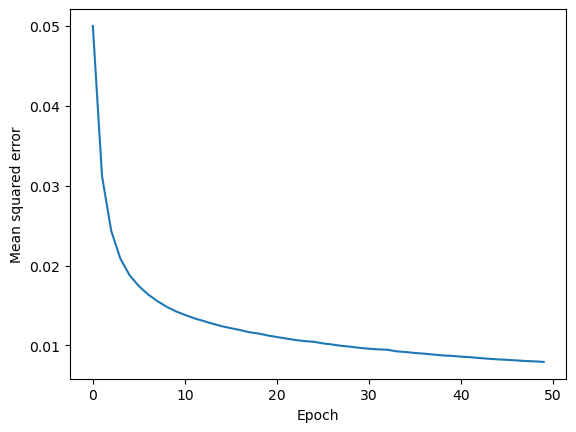

In [21]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

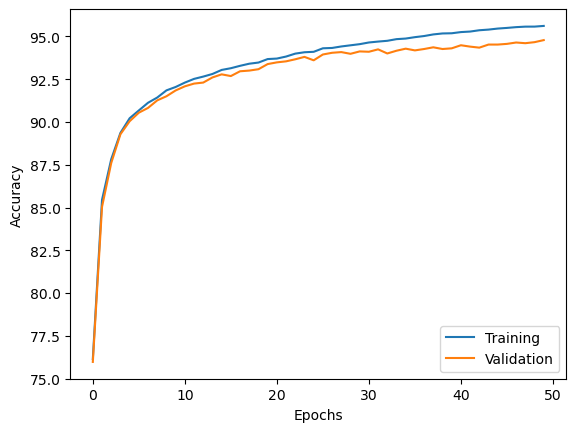

In [22]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [23]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'테스트 정확도 : {test_acc * 100:.2f}%')

테스트 정확도 : 94.54%


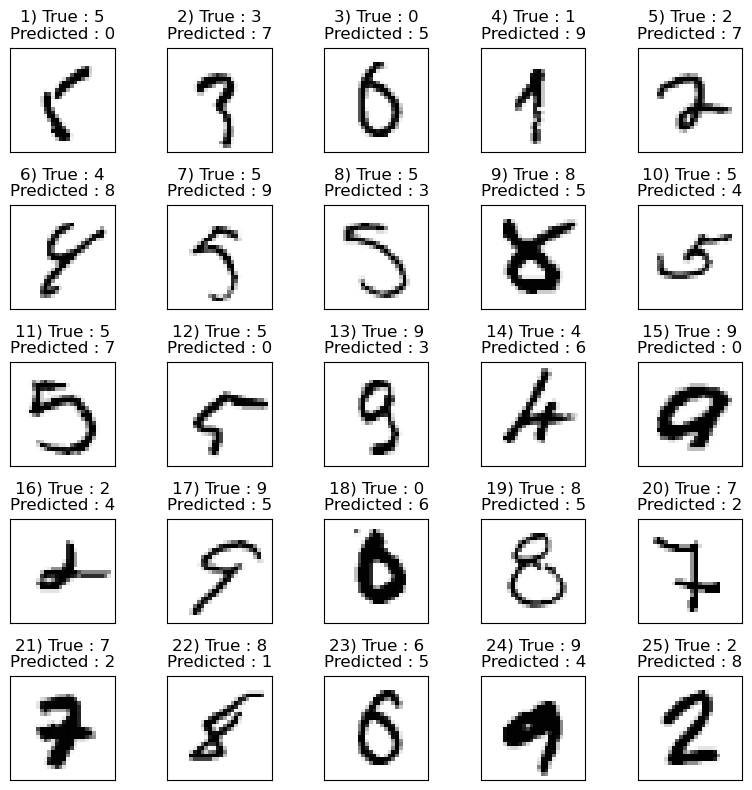

In [24]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i + 1}) '
                    f'True : {correct_labels[i]}\n'
                    f'Predicted : {misclassified_labels[i]}')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()